## Building ground for the visualization API.
**Will include the following:**
1. Visualization from Training TFRecord
2. Visualization from Predictions

In [2]:
%%writefile /home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/data_prep/tfr_visualization.py

"""Visualization API for:
1. Predictions
"""

import tensorflow as tf
import os, csv, io, sys
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import pyplot as plt
matplotlib.use('Agg')

tf.enable_eager_execution()

sys.path.append('/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/')

from data.utils import dataset_util


def decode_record_pred(serialized_example):
    """Decode the TFRecord data for each example. """
    context_features = {
                        'image/filename': tf.FixedLenFeature([], tf.string),
                        'image/encoded': tf.FixedLenFeature([], tf.string),
                        'image/format': tf.FixedLenFeature([], tf.string),
                        "image/detection/bbox/xmin" : tf.VarLenFeature(tf.float32),
                        "image/detection/bbox/xmax" : tf.VarLenFeature(tf.float32),
                        "image/detection/bbox/ymin" : tf.VarLenFeature(tf.float32),
                        "image/detection/bbox/ymax" : tf.VarLenFeature(tf.float32),
                        "image/detection/label" : tf.VarLenFeature(tf.int64),
                        "image/detection/score" : tf.VarLenFeature(tf.float32)
                    }


    context, sequence = tf.parse_single_sequence_example(serialized=serialized_example,
                                              context_features=context_features,
#                                               sequence_features=sequence_features,
                                              example_name=None,
                                              name=None)

    return ({k: v for k, v in context.items()},{k: v for k, v in sequence.items()})


def plot_images_with_bbox_pred(filename_list, outfile, inv_label_map, num_batches=1, 
                          score_threshold=0.5, batch_size= 2):
    """Plot n images with bounding boxes and save it in the location givenself.
    filename_list : list of TFRecords
    """

    # Create a tensorflow dataset
    dataset = tf.data.Dataset.from_tensor_slices(filename_list)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.shuffle(buffer_size=batch_size)
    dataset = dataset.map(lambda x: decode_record_pred(serialized_example=x)).batch(batch_size)

    for i, (context, sequence) in enumerate(dataset):
        if i<num_batches:
            batch_shape = context['image/detection/bbox/xmin'].dense_shape
            filename = context['image/filename']
            xmin_d = tf.sparse_tensor_to_dense(context['image/detection/bbox/xmin'])
            ymin_d = tf.sparse_tensor_to_dense(context['image/detection/bbox/ymin'])
            xmax_d = tf.sparse_tensor_to_dense(context['image/detection/bbox/xmax'])
            ymax_d = tf.sparse_tensor_to_dense(context['image/detection/bbox/ymax'])
            label_d = tf.sparse_tensor_to_dense(context['image/detection/label'])
            score = tf.sparse_tensor_to_dense(context['image/detection/score'])

            for rec_i in range(0, int(batch_shape[0])):
                xmins_d, ymins_d, xmaxs_d, ymaxs_d, labels_d, scores, filenames = [], [], [], [], [], [], []
                
                img = context['image/encoded'][rec_i]
                encoded_jpg_io = io.BytesIO(img.numpy())
                image = Image.open(encoded_jpg_io)
                width, height = image.size
                
                filenames.append(filename[rec_i].numpy().decode('utf-8'))
                
                for box_i in range(0, int(batch_shape[1])):                    
                    if score[rec_i, box_i] >= score_threshold:
#                         continue
                        xmins_d.append((xmin_d[rec_i, box_i].numpy())*width)
                        ymins_d.append((ymin_d[rec_i, box_i].numpy())*height)
                        xmaxs_d.append((xmax_d[rec_i, box_i].numpy())*width)
                        ymaxs_d.append((ymax_d[rec_i, box_i].numpy())*height)
                        labels_d.append(int(label_d[rec_i, box_i].numpy()))
                        scores.append(score[rec_i, box_i].numpy())

                # Create figure and axes
                fig,ax = plt.subplots(1)
                fig.set_size_inches(10, 8)
                # Display the image
                ax.set_title(filename[rec_i].numpy().decode('utf-8'))
                ax.imshow(image)
                for s in range(len(xmins_d)):
                    rect = patches.Rectangle((xmins_d[s],ymins_d[s]),(xmaxs_d[s]-xmins_d[s]), \
                                             (ymaxs_d[s] - ymins_d[s]),linewidth=2,edgecolor='b',facecolor='none')
                    ax.add_patch(rect)

                    rx, ry = rect.get_xy()
                    cx = rx # + rect.get_width()/2.0
                    cy = ry # + rect.get_height()/2.0

                    ax.annotate((inv_label_map[labels_d[s]], str(scores[s])+str('%')), (cx, cy), color='b', weight='bold', 
                                fontsize=8, ha='left', va='top') 
                fig.savefig(os.path.join(outfile, filename[rec_i].numpy().decode('utf-8').split('/')[-1]))
                plt.clf

/home/ubuntu/test_env/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/test_env/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/test_env/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ubuntu/test_env/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/u

In [31]:
%%writefile /home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/tfr_visualization_main.py
"""Main function for visualizing the predictions and saving 
them to a directory

python tfr_visualization_main.py \
--filename_list '/home/ubuntu/data/tensorflow/my_workspace/training_demo/Predictions/snapshot_serengeti_s01_s06-0-10000.record' \
--outfile '/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/test_images/' \
--label_map_json '/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/data/LILA/label_map.json' \
--num_batches 256
"""

import json, argparse
import matplotlib
matplotlib.use('Agg')


import data_prep.tfr_visualization as visual

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "--filename_list", nargs='+', type=str, required=True,
        help="Path to TFRecord files. In form of list")
    parser.add_argument(
        "--outfile", type=str, required=True,
        help="output directory of the image to be saved"
        )
    parser.add_argument(
    "--label_map_json", type=str, required=True,
    help="label map json"
    )
    parser.add_argument(
        "--num_batches", type=int, default=1,
        help="number of batches to save. batch size = 2"
    )
    parser.add_argument(
    "--score_threshold", type=float, default=0.5,
    help="threshold of the detected box to be plotted"
    )

    args = parser.parse_args()

    with open(args.label_map_json, 'r') as f:
         label_map = json.load(f)
    inv_label_map = {v: k for k, v in label_map.items()}
        
    visual.plot_images_with_bbox_pred(args.filename_list, args.outfile, inv_label_map, args.num_batches, score_threshold = args.score_threshold)

Writing /home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/tfr_visualization_main.py


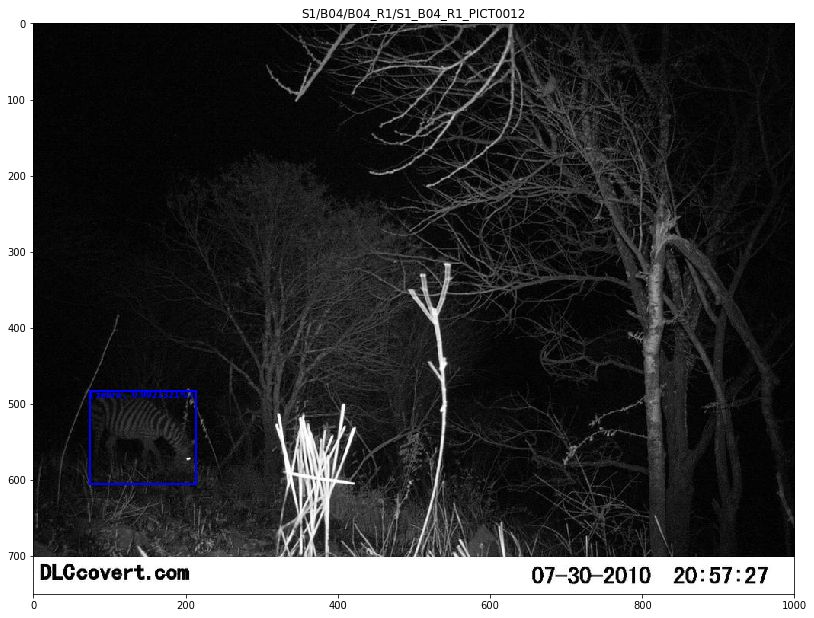

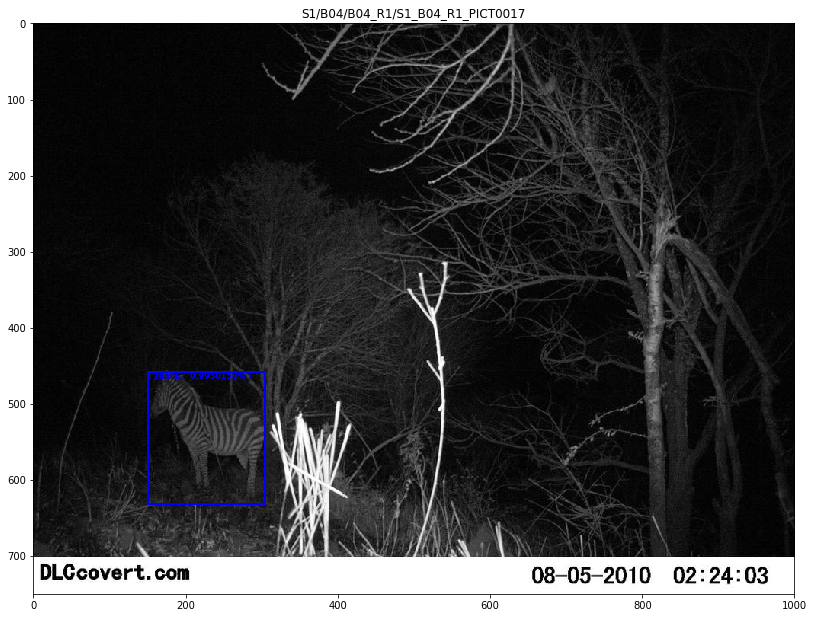

In [16]:
filename_list = '/home/ubuntu/data/tensorflow/my_workspace/training_demo/Predictions/snapshot_serengeti_s01_s06-0-10000.record'
outfile = '/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/'
label_map = '/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection//data/LILA/label_map.json'

with open(label_map, 'r') as f:
    label_map = json.load(f)
inv_label_map = {v: k for k, v in label_map.items()}

plot_images_with_bbox([filename_list], outfile, inv_label_map)

## Visualize MSI encoded images

In [1]:
import tensorflow as tf
import os, csv, io, sys, json
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import pyplot as plt
matplotlib.use('Agg')
tf.enable_eager_execution()

/home/ubuntu/test_env/lib/python3.5/site-packages/ipykernel_launcher.py:8: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/test_env/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/test_env/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ubuntu/test_env/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/ub

In [2]:
# tf.enable_eager_execution()

def decode_record_raw_image(serialized_example):
    context_features = {
                        'image/filename': tf.FixedLenFeature([], tf.string),
                        'image/encoded': tf.FixedLenFeature([], tf.string),
                        'image/format': tf.FixedLenFeature([], tf.string)
                    }


    context, sequence = tf.parse_single_sequence_example(serialized=serialized_example,
                                              context_features=context_features,
#                                               sequence_features=sequence_features,
                                              example_name=None,
                                              name=None)

    return ({k: v for k, v in context.items()},{k: v for k, v in sequence.items()})

def plot_images_raw(filename_list, outfile, num_batches=1, 
                          batch_size= 2):
    """Plot n raw images and save it in the location givenself.
    filename_list : list of TFRecords
    """

    # Create a tensorflow dataset
    dataset = tf.data.Dataset.from_tensor_slices(filename_list)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.shuffle(buffer_size=batch_size)
    dataset = dataset.map(lambda x: decode_record_raw_image(serialized_example=x)).batch(batch_size)

    for i, (context, sequence) in enumerate(dataset):
        if i<num_batches:
            for j in range(batch_size):
                img = context['image/encoded'][j]
                encoded_jpg_io = io.BytesIO(img.numpy())
                image = Image.open(encoded_jpg_io)
                width, height = image.size
                # Create figure and axes
                fig,ax = plt.subplots(1)
                fig.set_size_inches(10, 8)
                # Display the image
                ax.set_title(context['image/filename'][j].numpy().decode('utf-8'))
                ax.imshow(image)
                fig.savefig(os.path.join(outfile, context['image/filename'][j].numpy().decode('utf-8').split('/')[-1]))
                plt.clf


In [ ]:
              
filename_list = ['/home/ubuntu/species_detection/data/TFrecords/snapshot_serengeti_s01_s06_400000_599999.record-00099-of-00100']
outfile = '/home/ubuntu/species_detection/data/test_img/'
plot_images_raw(filename_list, outfile, num_batches=32, batch_size= 2)

## Building function to visualize the training data

In [2]:
# tf.enable_eager_execution()

def decode_record_training_image(serialized_example):
    context_features = {
                        'image/height': tf.FixedLenFeature([], tf.int64),
                        'image/width': tf.FixedLenFeature([], tf.int64),
                        'image/filename': tf.FixedLenFeature([], tf.string),
                        'image/source_id': tf.FixedLenFeature([], tf.string),
                        'image/encoded': tf.FixedLenFeature([], tf.string),
                        'image/format': tf.FixedLenFeature([], tf.string),
                        "image/object/bbox/xmin" : tf.VarLenFeature(tf.float32),
                        "image/object/bbox/xmax" : tf.VarLenFeature(tf.float32),
                        "image/object/bbox/ymin" : tf.VarLenFeature(tf.float32),
                        "image/object/bbox/ymax" : tf.VarLenFeature(tf.float32),
                        "image/object/class/text" : tf.VarLenFeature(tf.string),
                        "image/object/class/label" : tf.VarLenFeature(tf.int64)
                    }


    context, sequence = tf.parse_single_sequence_example(serialized=serialized_example,
                                              context_features=context_features,
#                                               sequence_features=sequence_features,
                                              example_name=None,
                                              name=None)

    return ({k: v for k, v in context.items()},{k: v for k, v in sequence.items()})

def plot_images_training(filename_list, outfile, inv_label_map, num_batches=1, 
                          batch_size= 2):
    """Plot n raw images and save it in the location givenself.
    filename_list : list of TFRecords
    """

    # Create a tensorflow dataset
    dataset = tf.data.Dataset.from_tensor_slices(filename_list)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.shuffle(buffer_size=batch_size)
    dataset = dataset.map(lambda x: decode_record_training_image(serialized_example=x)).batch(batch_size)

    for i, (context, sequence) in enumerate(dataset):
        if i<num_batches:
            batch_shape = context['image/object/bbox/xmin'].dense_shape
            filename = context['image/filename']
            xmin = tf.sparse_tensor_to_dense(context['image/object/bbox/xmin'])
            ymin = tf.sparse_tensor_to_dense(context['image/object/bbox/ymin'])
            xmax = tf.sparse_tensor_to_dense(context['image/object/bbox/xmax'])
            ymax = tf.sparse_tensor_to_dense(context['image/object/bbox/ymax'])
            label = tf.sparse_tensor_to_dense(context['image/object/class/label'])
            
            for rec_i in range(0, int(batch_shape[0])):
                xmins, ymins, xmaxs, ymaxs, labels = [], [], [], [], []

                img = context['image/encoded'][rec_i]
                encoded_jpg_io = io.BytesIO(img.numpy())
                image = Image.open(encoded_jpg_io)
                width, height = image.size
                
                for box_i in range(0, int(batch_shape[1])):   
                    xmins.append((xmin[rec_i, box_i].numpy())*width)
                    ymins.append((ymin[rec_i, box_i].numpy())*height)
                    xmaxs.append((xmax[rec_i, box_i].numpy())*width)
                    ymaxs.append((ymax[rec_i, box_i].numpy())*height)
                    labels.append(int(label[rec_i, box_i].numpy()))
                    
                # Create figure and axes
                fig,ax = plt.subplots(1)
                fig.set_size_inches(10, 8)
                # Display the image
                ax.set_title(filename[rec_i].numpy().decode('utf-8'))
                ax.imshow(image)
                for s in range(len(xmins)):
                    if int(labels[s]) != 0:
                        rect = patches.Rectangle((xmins[s],ymins[s]),(xmaxs[s]-xmins[s]), \
                                                 (ymaxs[s] - ymins[s]),linewidth=2,edgecolor='b',facecolor='none')
                        ax.add_patch(rect)
                        rx, ry = rect.get_xy()
                        cx = rx # + rect.get_width()/2.0
                        cy = ry # + rect.get_height()/2.0

                        ax.annotate(inv_label_map[labels[s]], (cx, cy), color='b', weight='bold', 
                                fontsize=8, ha='left', va='top') 
                fig.savefig(os.path.join(outfile, filename[rec_i].numpy().decode('utf-8').split('/')[-1]))
                plt.clf

In [ ]:
filename_list = ['/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/bootstrap_data_round1bootstrap_data_snapshot_serengeti_s01_s06_0_199999-00000-of-00100.record']
outfile = '/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/test_imgs_variable_threshold'
label_map = '/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection//data/LILA/label_map.json'

with open(label_map, 'r') as f:
    label_map = json.load(f)
inv_label_map = {v: k for k, v in label_map.items()}
   
plot_images_training(filename_list, outfile, inv_label_map, num_batches=256)

In [24]:
pwd

'/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/data_prep'